# HW1: Simple base model

### Input files needed:
- topography.csv - grid of land surface elevations 
- watershed.csv - grid of no-flow cells indicating the watershed boundary

### MODFLOW packages used:
- DIS - Discretization input
- BAS - Basic
- LPF - Layer-Property Flow
- OC  - Output Control
- PCG - Preconditioned Conjugate Gradient
- RCH - Recharge
    
### Model description:
This is a steady-state model of the watershed shown below.
![conceptual diagram of base model](sketch.png) <br>
The model has 50x50 cells, each measuring 1000 m in x and in y.  
There are two homogeneous, isotropic layers. 
The model has a bottom elevation of 0 m (this is the datum elevation) and a top elevation that corresponds to the land surface elevation.
The land surface elevation in meters above the datum is provided in the topography.csv file.
The boundary between the two layers is flat and is at an elevation of 50 m above the datum.
The porosity is 0.10, specific yield is 0.10, and storage coefficient is 0.0001. 
The hydraulic conductivity is 10 m/day in all three principal directions (x,y,z).

The edges of the watershed are bounded by impermeable bedrock on three sides.  These are represented as no-flow cells (a type of boundary condition) provided by the watershed.csv file.
The right (eastern) boundary has a constant head of 70 m relative to the datum.

Recharge occurs at a rate of 4E-5 m/day in the leftmost (western) 15 columns and is zero elsewhere.  

## Instructor notes

The "true" horizontal hydraulic conductivity is 52 m/day. <br>
Piezometer 1: layer 0, row 12, col 42, H = 73.539 m <br>
Piezometer 2: layer 0, row 30, col 15, H = 81.344 m <br>


## Import Python packages

In [1]:
import os
import numpy as np
import numpy.ma as ma
import csv                                             
import flopy
import flopy.utils.binaryfile as bf
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import LinearLocator, FormatStrFormatter

## Model setup

In [2]:
##Name:
modelname = "base"

##Grid:
nrow = 50          #number of rows
ncol = 50          #number of columns
delr = 1000.       #width of each cell along rows (so really this is column width along x axis)
delc = 1000.       #width of each cell along columns (so really this is row height along y axis)
Lx = ncol*delr     #width of domain in x (across columns) = number of columns x cell width
Ly = nrow*delc     #width of domain in y (across rows) = number of rows x cell height

##Layers:
nlay = 2                                                #number of layers
layers = np.arange(nlay)                                #make array of layers
ztop = np.genfromtxt('topography.csv', delimiter=',')   #import top elevation of model from csv file (dim: nrow,ncol)
zbot = 0.                                               #bottom elevation of model (datum)
botm = np.full((nlay,nrow,ncol),zbot)                   #make array of default cell bottom elevations for each cell in the model (dim:nlay,nrow,ncol)
botm[0,:,:] = 50.                                       #replace the cell bottom elevations in the top layer (layer 0) with the elevation of the boundary between layers

##Medium properties:
#Hydraulic conductivity:
#Kx and Ky:
K_horiz = 10.    #horizontal hydraulic conductivity (along rows)
K_ratio = 1.     #ratio of Ky/Kx (aka Kcol/Krow) - if Kx=Ky, ratio=1
#Kz:
K_vert = 10.     #vertical hydraulic conductivity (along z axis)

#Porosity, storage, specific yield, confined/unconfined:
n  = 0.1         #porosity
Ss = 0.0001      #storage coefficient
Sy = 0.1         #specific yield
uncnf = 1        #if 0 then confined, if >0 then unconfined

In [3]:
##Constant head boundary conditions:
#if ibound < 0, constant head; if ibound = 0, inactive/no-flow/outside of watershed; if ibound > 0, active.

#create arrays to indicate active cells and boundary conditions (ibound):
ibound = np.full((nlay,nrow,ncol),0)                            #make array of zeros for default boundary conditions (dim:nlay,nrow,ncol)
ibound[:,:,:] =  np.genfromtxt('watershed.csv', delimiter=',')  #import locations of active and inactive cells from csv (all layers, all rows, all cols)
ibound[:,11:41,ncol-1] = -1                                     #replace rightmost (eastern) column (slice all layers, active rows, last column) with -1 to indicate constant head

#create array of initial head values across the model and at the boundaries
H_init = 70.                                #initial hydraulic head in meters
strt = np.full((nlay, nrow, ncol), H_init)  #float (i.e. decimal) array, sets initial head in all cells to desired value

In [4]:
## Recharge conditions:
R = 4e-5                              #recharge rate [m/day]
rech = np.zeros((nrow,ncol))          #make array of zeros for recharge (dim: nrow, ncol, no layers because recharge only happens in top layer)
rech[:,0:15] = R                      #set recharge in the leftmost 15 columns to the desired recharge rate

In [5]:
##Outputs:
#this section usually does not change - we are telling the model which outputs to print

oc_spd = {(0,0):['print head', 'print budget', 'save head', 'save budget']} #create a dictionary for stress period data, where key (0,0) is associated with value ['print...']
ipakcb = 53    #unit to save cell-by-cell outputs to

In [6]:
#Create the model objects and the objects for each package
#Note: running this section multiple times without changing filenames (see block above) will overwrite the existing 
#files & generate a warning that existing packages are being replaced. This is fine.

#Create model object:
mf = flopy.modflow.Modflow(modelname, exe_name='mf2005')    #MODFLOW executable must be in same folder, named mf2005.exe
    
#Create objects for each package (see GHW1 notebook for details):
dis = flopy.modflow.ModflowDis(mf, nlay, nrow, ncol, delr=delr, 
                               delc=delc, top=ztop, botm=botm)         #DIS (Discretization): creates model grid   
bas = flopy.modflow.ModflowBas(mf, ibound=ibound, strt=strt)           #BAS (Basic): assigns head boundaries
lpf = flopy.modflow.ModflowLpf(mf, laytyp=uncnf, chani=0, hk=K_horiz, hani=K_ratio, vka=K_vert, 
        ss=Ss, sy=Sy, storagecoefficient=False, ipakcb=ipakcb)            #LPF (Layer Property Flow): assigns flow props between cells
oc = flopy.modflow.ModflowOc(mf, stress_period_data=oc_spd, compact=True) #OC (Output Control): Decides what outputs to save
pcg = flopy.modflow.ModflowPcg(mf)                                        #PCG (Preconditioned Conjugate Gradient)
rch = flopy.modflow.mfrch.ModflowRch(mf, rech=rech)                       #RCH (Recharge)

### Display summary of model inputs

Text(0.5, 1.0, 'land surface elevation [m]')

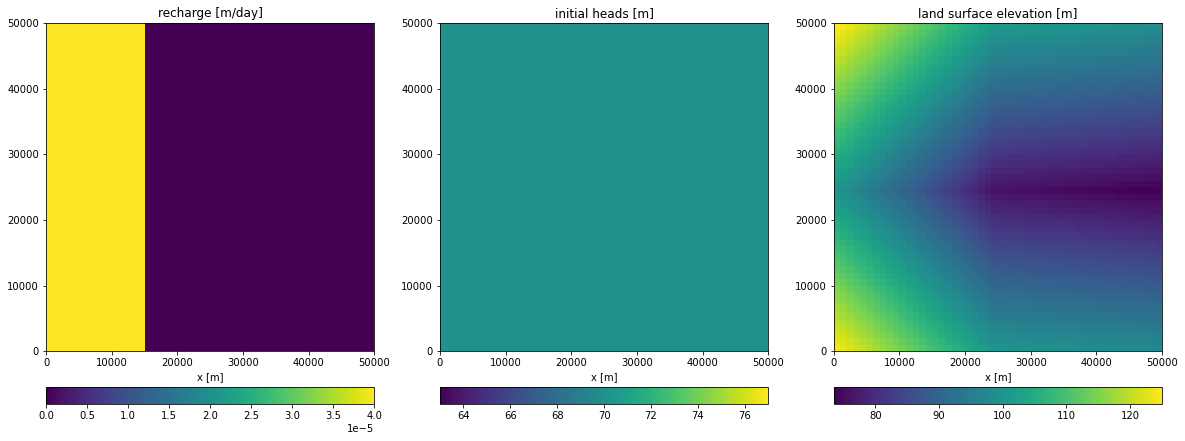

In [7]:
# Plot model setup with built-in FloPy tools
# note: this is for the top layer only!

#Set up axes
f,axes = plt.subplots(nrows=1,ncols=3,figsize=(20,15))  #create figure and axis objects with subplots for each parameter
maps = []                                               #create empty list to store maps of different model parameters
caxes = []                                              #create empty list to store different colorbar axes
for ax in axes:
    ax.set_aspect('equal') #set equal aspect ratio for all subplot axes
    m = flopy.plot.PlotMapView(model=mf, ax=ax, layer=0) #create map object
    ax.set_xlabel('x [m]')                               #set x axis label
    divider = make_axes_locatable(ax)                    #make axes dividable (to add colorbar)
    cax = divider.append_axes('bottom', size="5%", pad=0.5)   #add an axis at the bottom for the colorbar
    maps.append(m)                                            #add map object to list
    caxes.append(cax)                                         #add colorbar axis object to label
    

r = maps[0].plot_array(rech)
plt.colorbar(r, cax=caxes[0], orientation='horizontal')       #plot the colorbar
axes[0].set_title('recharge [m/day]')

h = maps[1].plot_array(strt[0,:,:])
plt.colorbar(h, cax=caxes[1], orientation='horizontal')       #plot the colorbar
axes[1].set_title('initial heads [m]')

h = maps[2].plot_array(ztop)
plt.colorbar(h, cax=caxes[2], orientation='horizontal')       #plot the colorbar
axes[2].set_title('land surface elevation [m]')

Text(0, 0.5, 'y [m]')

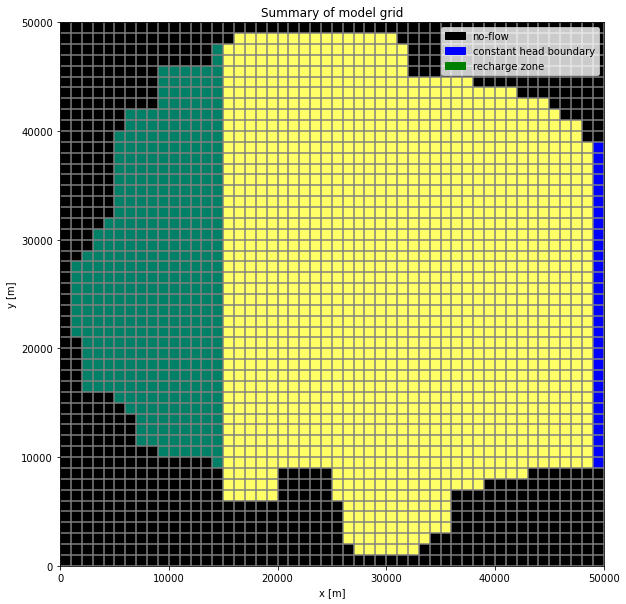

In [8]:
#Plot model boundary conditions summary:
f,ax = plt.subplots(1,1,figsize=(10,10))                    #create new figure and axes
plt.title('Summary of model grid')                          #set figure title
m = flopy.plot.PlotMapView(model=mf, layer=0)               #create model map object
grid = m.plot_grid(colors='gray')                           #plot model grid
r = m.plot_array(rech, cmap='summer_r')                                              #plot recharge array
bc = m.plot_ibound()                       #plot boundary conditions

#Format and legend
plt.legend(handles=[matplotlib.patches.Patch(color='black',label='no-flow'),      #add legend manually
                    matplotlib.patches.Patch(color='blue',label='constant head boundary'),
                    matplotlib.patches.Patch(color='green',label='recharge zone')])
ax.set_xlabel('x [m]')
ax.set_ylabel('y [m]')

Text(0.5, 1.0, 'west-east cross-section')

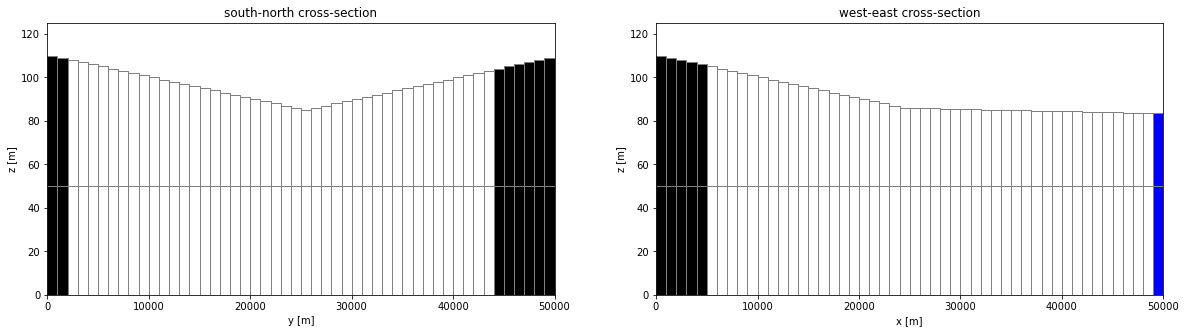

In [9]:
#Plot cross-section view of model:
f,ax = plt.subplots(1,2, figsize=(20,5))                                     #create empty figure and axes objects
xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[0], line={'Column': 15})   #plot cross-section along given column (change column # to see different locations)
bc = xsec.plot_ibound()                                                      #plot boundary conditions
g  = xsec.plot_grid()                                                        #plot model grid
ax[0].set_xlabel('y [m]')
ax[0].set_ylabel('z [m]')
ax[0].set_title('south-north cross-section')

xsec= flopy.plot.PlotCrossSection(model=mf, ax=ax[1], line={'Row': 15})      #plot cross-ection along given row
bc = xsec.plot_ibound()                                                      #plot boundary conditions
g  = xsec.plot_grid()                                                        #plot grid
ax[1].set_xlabel('x [m]')
ax[1].set_ylabel('z [m]')
ax[1].set_title('west-east cross-section')

## Run model
The code in this section will change very little other than adding packages

In [10]:
#Write MODFLOW input files:
mf.write_input()

#Run MODFLOW:
success, buff = mf.run_model()                 #you should see "normal termination of simulation" printed below

FloPy is using the following executable to run the model: .\mf2005.EXE

                                  MODFLOW-2005     
    U.S. GEOLOGICAL SURVEY MODULAR FINITE-DIFFERENCE GROUND-WATER FLOW MODEL
                             Version 1.12.00 2/3/2017                        

 Using NAME file: base.nam 
 Run start date and time (yyyy/mm/dd hh:mm:ss): 2021/11/29 12:00:24

 Solving:  Stress period:     1    Time step:     1    Ground-Water Flow Eqn.
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2021/11/29 12:00:24
 Elapsed run time:  0.166 Seconds

  Normal termination of simulation


In [11]:
#Run MODPATH for particle tracking:
mp = flopy.modpath.Modpath6(modelname=modelname+'_mp', exe_name='mp6.exe', 
        modflowmodel=mf, model_ws=None, dis_file=modelname+'.dis', 
        head_file=modelname+'.hds', budget_file=modelname+'.cbc')                 #create MODPATH model object
mpb = flopy.modpath.Modpath6Bas(mp, hdry=mf.lpf.hdry, laytyp=mf.lpf.laytyp, 
        ibound=ibound, prsity=n)                                                  #create MODPATH BAS object
sim = mp.create_mpsim(trackdir='forward', simtype='pathline', packages='RCH')     #create MODPATH simulation

mp.write_input()                 #write MODPATH input files
mp.run_model(silent=False)       #run MODPATH - you should see "Normal termination" printed below

FloPy is using the following executable to run the model: .\mp6.exe
Processing basic data ...
Checking head file ...
Checking budget file and building index ...
 
Run particle tracking simulation ...
Processing Time Step     1 Period     1.  Time =  1.00000E+00                                                                       
Particle tracking complete. Writing endpoint file ...                                                                               
End of MODPATH simulation. Normal termination.


(True, [])

## Post-process and display results
Extract the raw output data and convert it into a format that's meaningful for humans

In [22]:
##Get outputs:
#This section usually does not change much

#Get MODFLOW outputs:
hds = bf.HeadFile(modelname+'.hds')    #reads the raw binary head output file 
times = hds.get_times()                #returns a list of timesteps
head = hds.get_data(totim=times[-1])   #returns an array of heads for the specified time (last timestep)
head_mx = ma.masked_values (head, -999.99)  #make a masked head array where all no-flow cells (with the value -999.99) are hidden

#Get cell-by-cell outputs from the cell budget output file:
#string options are in the list file under output control (make sure to include spaces!)
cbb = bf.CellBudgetFile(modelname+'.cbc')   #reads the cell budget file    
kstpkper_list = cbb.get_kstpkper()          #returns a list of stress periods & timesteps
frf = cbb.get_data(text='FLOW RIGHT FACE', totim=times[-1])[0]      #returns an array of flow rates for right face of cells
fff = cbb.get_data(text='FLOW FRONT FACE', totim=times[-1])[0]      #returns an array of flow rates for front face of cells

#Get MODPATH outputs:    
endobj = flopy.utils.EndpointFile(modelname+'_mp.mpend')   #get the raw MODPATH endpoint file
ept = endobj.get_alldata()                                 #import the endpoint data to FloPy
#convert ept to an array:
ept_array = np.zeros((len(ept),len(ept[0])-1))             #create an empty array the same dimensions as the ept file
for row in np.arange(len(ept)):                            #loop over the ept file rows
    for col in np.arange(len(ept[0])-1):                   #loop over the ept file columns (except the last one)
        ept_array[row,col] = ept[row][col]                 #assign each ept item to the array

In [23]:
#Display water budget:

#Get water budget information:
lst = flopy.utils.MfListBudget(modelname+'.list')       #read the list file
budget = lst.get_data()                                 #get cumulative water budget for last timestep
labels = [str(budget[i][2])[2:] for i in np.arange(len(budget))] #get and trim labels for each budget item (one-line for loop)
vals = [budget[i][1] for i in np.arange(len(budget))]   #get values for each budget item

#Print water budget:
print('%25s'%'MASS BALANCE','\n')   #print right-justified header taking up 25 spaces, then go to new line
b=[print("%25s"%labels[i],'\t',"%10s"%vals[i]) for i in np.arange(len(budget))]  #iterate to print each item in buget

#Print timesteps:
print('\ntimesteps:',times)
print('stress periods:', kstpkper_list)

             MASS BALANCE 

              STORAGE_IN' 	        0.0
        CONSTANT_HEAD_IN' 	        0.0
             RECHARGE_IN' 	    15400.0
                TOTAL_IN' 	    15400.0
             STORAGE_OUT' 	       -0.0
       CONSTANT_HEAD_OUT' 	   -15400.0
            RECHARGE_OUT' 	       -0.0
               TOTAL_OUT' 	   -15400.0
                  IN-OUT' 	        0.0
     PERCENT_DISCREPANCY' 	        0.0

timesteps: [1.0]
stress periods: [(0, 0)]


In [57]:
#Get hydraulic head at a specific location (the head you would measure if you installed a piezometer there):

lay = 0
row = 12
col = 42
h = head[lay,row,col]
piezo = np.full((nlay,nrow,ncol), np.nan)
piezo[lay,row,col] = 1

text = 'Head at layer {}, row {}, col {}: \t{:.3f} m'   #text to print (print last one with only 3 decimal places)
print(text.format(lay,row,col,h))  #print and fill curly brackets above with parameter values


Head at layer 0, row 12, col 42: 	75.517 m


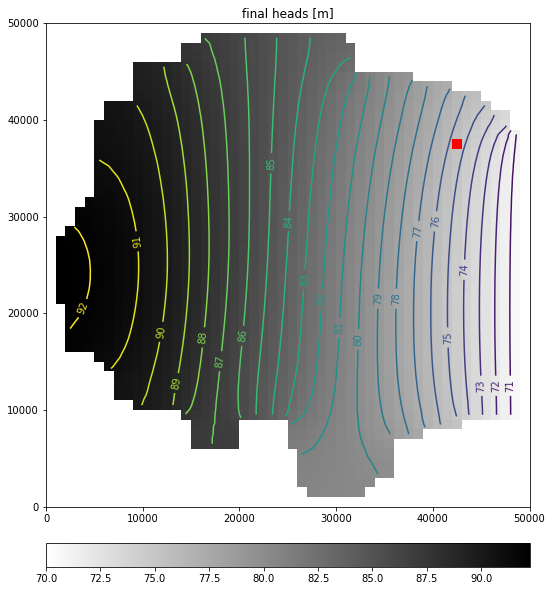

In [62]:
#Examine the hydraulic heads in layer 1 at the end of the model run

f,ax = plt.subplots(1,1, figsize=(10,10))         #create figure and axis objects
ax.set_title('final heads [m]')                   #set figure title

maps = flopy.plot.PlotMapView(model=mf)           #create flopy map object
h = maps.plot_array(head[0,:,:], masked_values=[-999.99], cmap='binary')  #plot heads as grayscale map
levels = np.arange(head_mx.min(), head_mx.max(), 1)                       #set contour range and interval
c = maps.contour_array(head[0,:,:], masked_values=[-999.99], levels=levels, cmap='viridis') #plot head contours
plt.clabel(c, rightside_up=False)   #add contour labels, not oriented for reading but for contour direction  
p = maps.plot_array(piezo, cmap='hsv')           #plot piezo

#Add colorbar:
divider = make_axes_locatable(ax)                         #make axes dividable (to add colorbar)
cax = divider.append_axes('bottom', size="5%", pad=0.5)   #add an axis at the bottom for the colorbar
plt.colorbar(h, cax=cax, orientation='horizontal')       #plot the colorbar

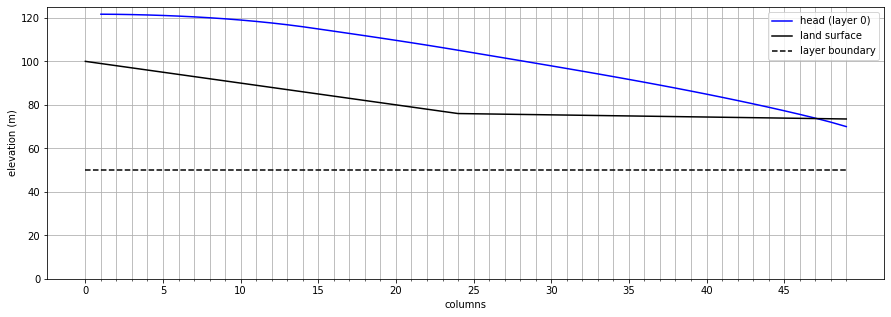

In [233]:
#Plot cross-section of heads along center row:
    
#Create figure & plot data:
f,ax = plt.subplots(1,1,figsize=(15,5))  #create a figure object of width 15 in and height 5 in, with two subplots
ax.plot(np.arange(ncol), head_mx[0,nrow//2,:], color='blue',  label='head (layer 0)') #plots heads at layer 0, center row, all columns

#Display layers:
ax.plot(np.arange(ncol), ztop[nrow//2,:],   color='k', label='land surface')    #plot top elevation of top layer (land surface)
ax.plot(np.arange(ncol), botm[0,nrow//2,:], color='k', linestyle='--', label='layer boundary')  #plot bottom elevation of top layer

#Format grid & axes:
major_ticks = np.arange(0,nrow,5)      #create array for major tick marks every 5
minor_ticks = np.arange(0,nrow)        #create array for minor tick marks every 1
ax.set_xticks(major_ticks)             #set major ticks
ax.set_xticks(minor_ticks, minor=True) #set minor ticks
ax.grid(which='both')                  #turn grid on for both major and minor ticks  
ax.set_ylim(bottom=zbot, top=np.amax(ztop))       #sets z limits to model bottom and highest top elev
ax.set_ylabel('elevation (m)')         #add axis label
ax.set_xlabel('columns')               #add axis label

#Legend:
ax.legend()

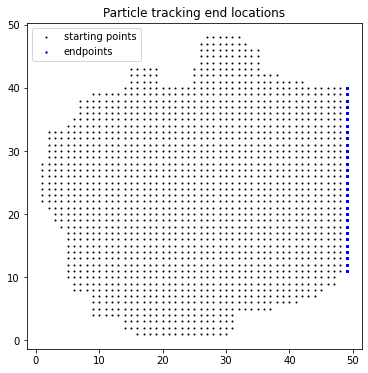

In [234]:
#Plot endpoints of particles:
#see https://pubs.usgs.gov/tm/6a41/pdf/TM_6A_41.pdf (p.33) 
#for information on what the columns of the endpoint file correspond to
#the ept slices are extracting location data from the relevant columns

f,ax = plt.subplots(1,1,figsize=(6,6))                                  #create & return figure & axes of size 6x6 inches
plt.scatter(ept_array[:,8],ept_array[:,7],   s=1, c='black', label='starting points')    #plot start locations in black 
plt.scatter(ept_array[:,20],ept_array[:,19], s=2, c='blue',  label='endpoints')          #plot end locations in blue
plt.title('Particle tracking end locations')                             #add title
plt.legend()                                                             #add legend

### Export data

In [235]:
np.savetxt('head_layer0.csv', head[0,:,:], delimiter=',')
np.savetxt('head_layer1.csv', head[1,:,:], delimiter=',')